In [3]:
#installations (*note*: pyscf only works on OSX locally. Could run it through Google Colab)
!pip install qiskit
!pip install qiskit_nature
!pip install pyscf[all]
!pip install qiskit_ibm_provider

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.3/241.3 KB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 3

In [11]:
#imports
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit_nature.algorithms import (GroundStateEigensolver,
                                      NumPyMinimumEigensolverFactory)
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper

import matplotlib.pyplot as plt
import numpy as np
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit.opflow import TwoQubitReduction
from qiskit import BasicAer, Aer, IBMQ
from qiskit.utils import QuantumInstance
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit_ibm_provider import IBMProvider

In [12]:
def HEA_naive(num_q, depth):
    circuit = QuantumCircuit(num_q)
    params = ParameterVector("theta", length=num_q * (3 * depth + 2))
    counter = 0
    for q in range(num_q):
        circuit.rx(params[counter], q)
        counter += 1
        circuit.rz(params[counter], q)
        counter += 1
    for d in range(depth):
        for q in range(num_q - 1):
            circuit.cx(q, q + 1)
        for q in range(num_q):
            circuit.rz(params[counter], q)
            counter += 1
            circuit.rx(params[counter], q)
            counter += 1
            circuit.rz(params[counter], q)
            counter += 1
    return circuit, params

In [13]:
qubit_converter = QubitConverter(ParityMapper(), two_qubit_reduction=True)
numpy_solver = NumPyMinimumEigensolver()

In [14]:
#calculates the exact ground state energy for BeH2 with classical computing
def exact_solver(problem):
    calc = GroundStateEigensolver(qubit_converter, numpy_solver)
    result = calc.solve(problem)
    return result


In [15]:
#calculates the approximate ground state energy for BeH2 with quantum computing
def vqe_solver(problem, circuit):
    calc = GroundStateEigensolver(qubit_converter, circuit)
    result = calc.solve(problem)
    return result


In [16]:
hub = "ibm-q"#"qhack-event"
group = "open"#"main"
project = "main"#"project-1"
backend_name = "ibm_oslo"
hgp = f"{hub}/{group}/{project}"

provider = IBMProvider()
backend = provider.get_backend(backend_name, instance=hgp)
qi = QuantumInstance(backend)

distances1 = np.arange(0.5, 2.0, 0.2)
distances2 = np.arange(2.1, 4.0, 0.4)
distances = np.concatenate([distances1, distances2])

exact_energies = []
vqe_energies = []
vqe_energy_numbers = []
exact_energy_numbers = [] 

optimizer = SLSQP()
for dist in distances:
    molecule = Molecule(geometry=[
        ["H", [0.0, 0.0, dist]],
        ["Be", [0.0, 0.0, 0.0]],
        ["H", [0.0, 0.0, -dist]]
    ],
    multiplicity=1,
    charge=0,
    )

    driver = ElectronicStructureMoleculeDriver(molecule=molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF)

    properties = driver.run()
    num_particles = (properties.get_property("ParticleNumber").num_particles)
    num_spin_orbitals = int(properties.get_property("ParticleNumber").num_spin_orbitals)

    problem = ElectronicStructureProblem(driver, [FreezeCoreTransformer(freeze_core=True, remove_orbitals=[4, 5])])
    second_q_ops = problem.second_q_ops() 
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
    
    exact_energies.append(exact_solver(problem))
    circuit = HEA_naive(6,3)[0]
    VQE_circuit = VQE(ansatz=circuit, quantum_instance=qi, optimizer=optimizer)
    vqe_energies.append(vqe_solver(problem, VQE_circuit))
    
    vqe_energy = str(vqe_energies[-1]).split(":")[5].split()[0]
    vqe_energy_numbers.append(float(vqe_energy))
    exact_energy = str(exact_energies[-1]).split(":")[5].split()[0]
    exact_energy_numbers.append(float(exact_energy))
    print(f"Length {dist} VQE Energy {vqe_energy} Exact Energy {exact_energy}")
    
print("All energies calculated")

AccountNotFoundError: ignored

In [ ]:
backend = BasicAer.get_backend("statevector_simulator")
qi = QuantumInstance(backend)

distances1 = np.arange(0.5, 2.0, 0.2)
distances2 = np.arange(2.1, 4.0, 0.4)
distances = np.concatenate([distances1, distances2])
exact_energies = []
vqe_energies = []
vqe_energy_numbers = []
exact_energy_numbers = [] 

optimizer = SLSQP()
for dist in distances:
    molecule = Molecule(geometry=[
        ["H", [0.0, 0.0, dist]],
        ["Be", [0.0, 0.0, 0.0]],
        ["H", [0.0, 0.0, -dist]]
    ],
    multiplicity=1,
    charge=0,
    )

    driver = ElectronicStructureMoleculeDriver(molecule=molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF)

    properties = driver.run()
    num_particles = (properties.get_property("ParticleNumber").num_particles)
    num_spin_orbitals = int(properties.get_property("ParticleNumber").num_spin_orbitals)

    problem = ElectronicStructureProblem(driver, [FreezeCoreTransformer(freeze_core=True, remove_orbitals=[4, 5])])
    second_q_ops = problem.second_q_ops()  
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
    
    exact_energies.append(exact_solver(problem))
    circuit = HEA_naive(6,3)[0]
    VQE_circuit = VQE(ansatz=circuit, quantum_instance=qi, optimizer=optimizer)
    vqe_energies.append(vqe_solver(problem, VQE_circuit))
    
    vqe_energy = str(vqe_energies[-1]).split(":")[5].split()[0]
    vqe_energy_numbers.append(float(vqe_energy))
    exact_energy = str(exact_energies[-1]).split(":")[5].split()[0]
    exact_energy_numbers.append(float(exact_energy))
    print(f"Length {dist} VQE Energy {vqe_energy} Exact Energy {exact_energy}")

print("All energies calculated")

Text(0.5, 1.0, 'BeH2')

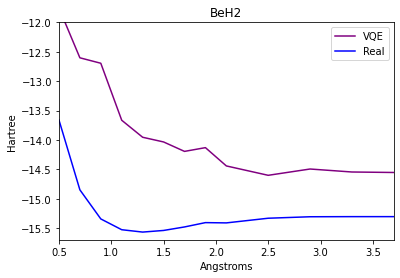

In [ ]:
x = distances
y = vqe_energy_numbers
y2 = exact_energy_numbers
plt.scatter(x, y, label='VQE', color='black')
plt.plot(x, y2, label='Real', color='purple')
plt.xlim(0.5, 3.7)
plt.ylim(-15.7, -12)
plt.xlabel('Angstroms')
plt.ylabel('Hartree')
plt.legend()
plt.title('BeH2')